# note that we are using sensor-wise normalization

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, LeaveOneGroupOut, StratifiedGroupKFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import xgboost as xgb
import warnings
import os

In [3]:
def evaluator(y_pred, y_test, verbose=False):
    """Returns evaluation metric scores"""
    accuracy = accuracy_score(y_pred=y_pred, y_true=y_test)
    balanced_accuracy = balanced_accuracy_score(y_pred=y_pred, y_true=y_test)
    f1 = f1_score(y_pred=y_pred, y_true=y_test, average='weighted')
    recall = recall_score(y_pred=y_pred, y_true=y_test, average='weighted')
    precision = precision_score(y_pred=y_pred, y_true=y_test, average='weighted')
    confusion = confusion_matrix(y_pred=y_pred, y_true=y_test)

    # display scores
    if verbose:
        ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=[False, True]).plot(cmap=plt.cm.Blues)
        plt.title('Physical fatigue')

        print(f'accuracy: {accuracy}\n'
              f'balanced accuracy: {balanced_accuracy}\n'
              f'f1 (weighted): {f1}\n'
              f'recall (weighted): {recall}\n'
              f'precision (weighted): {precision}')

    return {'accuracy': accuracy,
            'balanced_accuracy': balanced_accuracy,
            'f1': f1,
            'recall': recall,
            'precision': precision,
            'confusion': confusion}

In [4]:
VARIABLES = ['ActivityCounts', 'Barometer', 'BloodPerfusion',
             'BloodPulseWave', 'EnergyExpenditure', 'GalvanicSkinResponse', 'HR',
             'HRV', 'RESP', 'Steps', 'SkinTemperature', 'ActivityClass']

In [5]:
NORMALIZE_TRAIN = True # whether to normalize data acc. to training data
SHUFFLE = True # whether to shuffle data before applying CV

In [6]:
# for reproducability
SEED = 42

# Import data

In [7]:
# file path to data folder
path = './Output'

In [8]:
N, FEATURES = sum([1 for p in os.listdir(path) if p[:19] == 'feature_vector_stat']), \
              *np.load(path + '/feature_vector_stat0.npy').shape
print(f'datapoints: {N}, features: {FEATURES}')

datapoints: 317, features: 284


Feature vector, labels

In [9]:
# init
X = np.empty((N, FEATURES))
y = np.empty((N, 2))

# load individual datapoints
for i in range(N):
    X[i, ] = np.load(path + f'/feature_vector_stat{i}.npy', allow_pickle=True)
    y[i, ] = np.load(path + f'/labels_stat{i}.npy', allow_pickle=True)

Metadata (subjectID etc.)

In [10]:
with open(path + '/metadata_stat.txt') as f:
    metadata = f.read()

metadata = json.loads(metadata.replace('\'', '\"').replace('False', 'false').replace('True', 'true')) # doesn't accept other chars

# XGBoost

### test whether main difficulty subj.-variability or classification

1) give model subject information

In [13]:
subjects = [meta['subjectID'] for meta in metadata]
y_phf, y_mf = y[:, 0], y[:, 1]

In [12]:
X_mod = np.append(X, np.array(subjects).reshape(-1, 1), axis=1)

In [14]:
%%time
# nested CV
folds = 5

with warnings.catch_warnings():
    # ignore sklearn warning
    warnings.filterwarnings('ignore')

    for fatigue in ('Physical fatigue', 'Mental fatigue'):
        # load labels
        print(f'Starting cross-validation for {fatigue}')
        y_ = {'Physical fatigue': y_phf, 'Mental fatigue': y_mf}[fatigue] # pick phF or MF

        # CV: performance evaluation
        cv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=SEED) if SHUFFLE \
            else StratifiedKFold(n_splits=folds)
        scores_cv = []
        with tqdm(total=folds) as pbar:
            for i, (train_outer_index, test_outer_index) in enumerate(cv.split(X_mod, y_)):
                # train/test split
                X_train, X_test = X_mod[train_outer_index], X_mod[test_outer_index]
                y_train, y_test = y_[train_outer_index], y_[test_outer_index]

                # normalize features (acc.to train set)
                if NORMALIZE_TRAIN:
                    scaler = StandardScaler()
                    scaler.fit(X_train)
                    X_train = scaler.transform(X_train, copy=True)
                    X_test = scaler.transform(X_test, copy=True)

                # model
                model = xgb.XGBClassifier(random_state=SEED, verbosity=0)

                # training
                model.fit(X_train, y_train)

                # evaluate
                y_pred = model.predict(X_test)
                scores = evaluator(y_pred, y_test, verbose=False)
                scores_cv.append(scores)

                # for progress bar
                pbar.update(1)
                pbar.set_description(f' Fold {i+1} F1: {scores["f1"]}')

        # final evaluation
        print('Performance model:')
        metrics = scores_cv[0].keys()
        for metric in metrics:
            # ignore confusion_matrix
            if metric == 'confusion':
                continue
            mean = np.mean([scores_cv_i[metric] for scores_cv_i in scores_cv])
            std = np.std([scores_cv_i[metric] for scores_cv_i in scores_cv])
            print(f' {metric}: {round(mean, 3)} +- {round(std, 3)} \n')

Starting cross-validation for Physical fatigue


 Fold 5 F1: 0.7210884353741497: 100%|██████████| 5/5 [00:00<00:00,  9.21it/s]


Performance model:
 accuracy: 0.789 +- 0.033 

 balanced_accuracy: 0.64 +- 0.051 

 f1: 0.765 +- 0.038 

 recall: 0.789 +- 0.033 

 precision: 0.771 +- 0.046 

Starting cross-validation for Mental fatigue


 Fold 5 F1: 0.6413129598189022: 100%|██████████| 5/5 [00:00<00:00, 11.39it/s]

Performance model:
 accuracy: 0.691 +- 0.049 

 balanced_accuracy: 0.578 +- 0.061 

 f1: 0.662 +- 0.055 

 recall: 0.691 +- 0.049 

 precision: 0.661 +- 0.069 

CPU times: user 5.82 s, sys: 653 ms, total: 6.47 s
Wall time: 1.01 s


2) only use one subject as dataset

In [24]:
for subj in (23, 24, 25, 27):
    X_subj = X[[subject == subj for subject in subjects], :]
    y_subj = y[[subject == subj for subject in subjects], :]
    y_phf_subj, y_mf_subj = y_subj[:, 0], y_subj[:, 1]

    # nested CV
    folds = 5

    with warnings.catch_warnings():
        # ignore sklearn warning
        warnings.filterwarnings('ignore')

        for fatigue in ('Physical fatigue', 'Mental fatigue'):
            # load labels
            print(f'(subject {subj}) Starting cross-validation for {fatigue}')
            y_ = {'Physical fatigue': y_phf_subj, 'Mental fatigue': y_mf_subj}[fatigue] # pick phF or MF

            # CV: performance evaluation
            cv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=SEED) if SHUFFLE \
                else StratifiedKFold(n_splits=folds)
            scores_cv = []
            for i, (train_outer_index, test_outer_index) in enumerate(cv.split(X_subj, y_)):
                # train/test split
                X_train, X_test = X_subj[train_outer_index], X_subj[test_outer_index]
                y_train, y_test = y_[train_outer_index], y_[test_outer_index]

                # normalize features (acc.to train set)
                if NORMALIZE_TRAIN:
                    scaler = StandardScaler()
                    scaler.fit(X_train)
                    X_train = scaler.transform(X_train, copy=True)
                    X_test = scaler.transform(X_test, copy=True)

                # model
                model = xgb.XGBClassifier(random_state=SEED, verbosity=0)

                # training
                model.fit(X_train, y_train)

                # evaluate
                y_pred = model.predict(X_test)
                scores = evaluator(y_pred, y_test, verbose=False)
                scores_cv.append(scores)

            # final evaluation
            print('Performance model:')
            metrics = scores_cv[0].keys()
            for metric in metrics:
                # ignore confusion_matrix
                if metric == 'confusion':
                    continue
                mean = np.mean([scores_cv_i[metric] for scores_cv_i in scores_cv])
                std = np.std([scores_cv_i[metric] for scores_cv_i in scores_cv])
                print(f' {metric}: {round(mean, 3)} +- {round(std, 3)} \n')

(subject 23) Starting cross-validation for Physical fatigue
Performance model:
 accuracy: 0.586 +- 0.139 

 balanced_accuracy: 0.585 +- 0.137 

 f1: 0.586 +- 0.138 

 recall: 0.586 +- 0.139 

 precision: 0.59 +- 0.136 

(subject 23) Starting cross-validation for Mental fatigue
Performance model:
 accuracy: 0.614 +- 0.097 

 balanced_accuracy: 0.596 +- 0.105 

 f1: 0.606 +- 0.106 

 recall: 0.614 +- 0.097 

 precision: 0.604 +- 0.11 

(subject 24) Starting cross-validation for Physical fatigue
Performance model:
 accuracy: 0.947 +- 0.033 

 balanced_accuracy: 0.594 +- 0.203 

 f1: 0.932 +- 0.036 

 recall: 0.947 +- 0.033 

 precision: 0.917 +- 0.041 

(subject 24) Starting cross-validation for Mental fatigue
Performance model:
 accuracy: 0.832 +- 0.039 

 balanced_accuracy: 0.488 +- 0.015 

 f1: 0.774 +- 0.037 

 recall: 0.832 +- 0.039 

 precision: 0.724 +- 0.038 

(subject 25) Starting cross-validation for Physical fatigue
Performance model:
 accuracy: 0.3 +- 0.267 

 balanced_accurac

ValueError: n_splits=5 cannot be greater than the number of members in each class.

# PCA

In [58]:
import pandas as pd
import copy

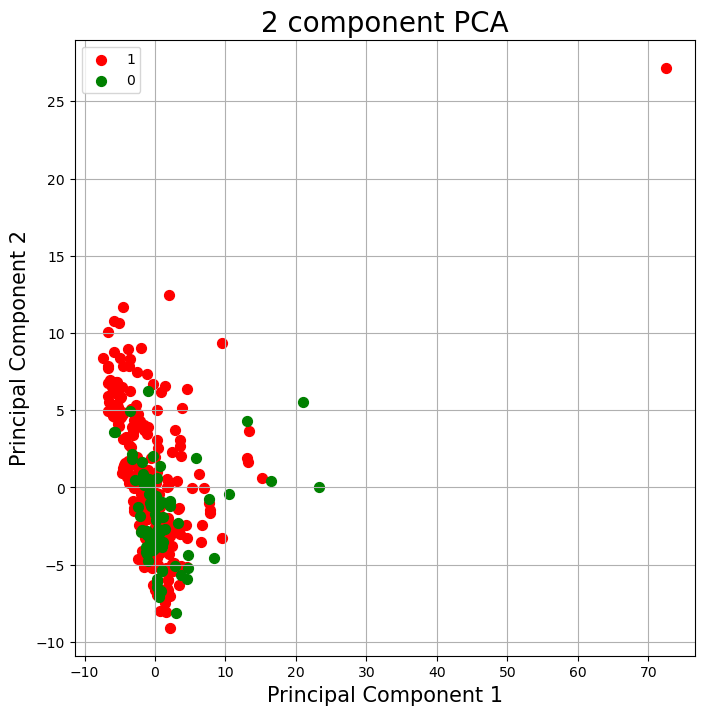

In [59]:
# copy
X_temp = copy.deepcopy(X)
y_temp = copy.deepcopy(y_phf)

# normalize
scaler_temp = StandardScaler()
X_temp = scaler_temp.fit_transform(X_temp)

# PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_temp)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

# concat labels
labels_temp = pd.DataFrame(data = y_temp, columns = ['target'])
finalDf = pd.concat([principalDf, labels_temp[['target']]], axis = 1)

# plot
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [1, 0]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

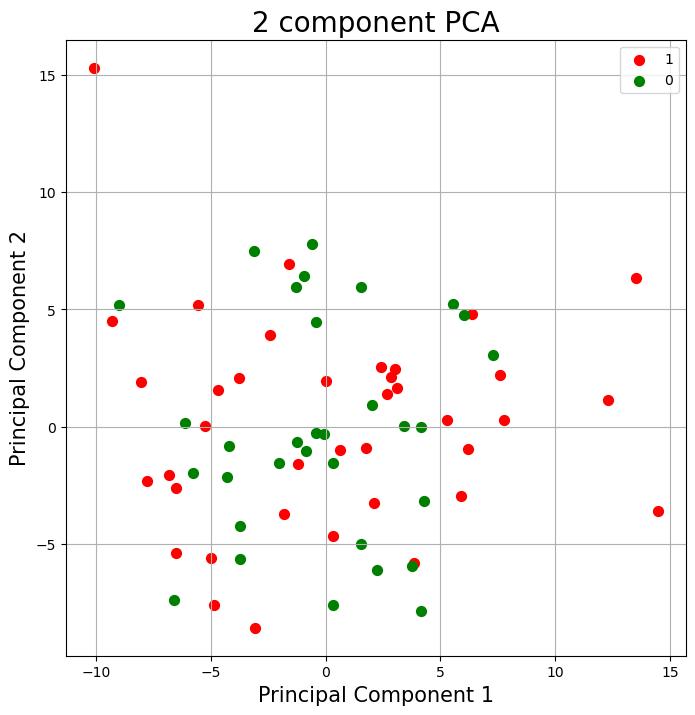

In [71]:
# copy
subj = 23
X_temp = X[[subject == subj for subject in subjects], :]
y_temp = y[[subject == subj for subject in subjects], :][:, 0]

# normalize
scaler_temp = StandardScaler()
X_temp = scaler_temp.fit_transform(X_temp)

# PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_temp)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

# concat labels
labels_temp = pd.DataFrame(data = y_temp, columns = ['target'])
finalDf = pd.concat([principalDf, labels_temp[['target']]], axis = 1)

# plot
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [1, 0]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()